# **Processamento de Streams Projeto II**
## Sofia Begonha Morgado + Vitor Borges Rodrigues

# Import libraries and data

In [ ]:
!pip install river

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.0 MB/s 


In [ ]:
from google.colab import files
import datetime as dt
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import random 

#Stream machine learning package
import river
from river import tree,feature_extraction,stats,ensemble,metrics,evaluate,preprocessing,compose
from river.linear_model import LogisticRegression
from river.naive_bayes import MultinomialNB
from river.feature_extraction import BagOfWords,TFIDF
from river.compose import Pipeline
from river import stream
from river import neural_net as nn
from river import ensemble, compose, preprocessing
from river import metrics, evaluate
from river import optim
from river import datasets
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import feature_extraction
from river import stats
from river import ensemble
from river import neighbors, stream, tree
from river import drift
from river import feature_extraction as fx
from river import neighbors

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/sns_df.csv", parse_dates=['Acquisition_Time'])

# Descriptive analysis

### Data - general aspects and descritive analysis

In [ ]:
#Visualize some examples
data.head()

,Unnamed: 0,Acquisition_Time,Hospital,Urgency_Type,Service,Emergency_Stage,Waiting_Time,People_Waiting,H_Name
0,0,2017-11-15 00:01:10,211,Urgncia Polivalente,Espera: Medicina Interna,4,17,0,S Jose
1,1,2017-11-15 00:01:10,211,Urgncia Polivalente,Espera: Medicina Interna,3,34,0,S Jose
2,2,2017-11-15 00:01:10,211,Urgncia Polivalente,Espera: Cirurgia Geral,3,6,0,S Jose
3,3,2017-11-15 00:01:10,211,Urgncia Polivalente,Espera: Oftalmologia,3,5,0,S Jose
4,4,2017-11-15 00:01:10,211,Urgncia Polivalente,Espera: Medicina Interna,2,309,8,S Jose


In [ ]:
#How many features and how many examples?
print(data.shape) 

(1603384, 9)


In [ ]:
#See if there are missing values
data.count()

Unnamed: 0          1603384
Acquisition_Time    1603384
Hospital            1603384
Urgency_Type        1603384
Service             1603384
Emergency_Stage     1603384
Waiting_Time        1603384
People_Waiting      1603384
H_Name              1603384
dtype: int64

### Categorical Features

In [ ]:
data["H_Name"].unique()

array(['S Jose', 'Santa Maria', 'SFX', 'Estefania'], dtype=object)

In [ ]:
data["Service"].unique()

array(['Espera: Medicina Interna', 'Espera: Cirurgia Geral',
       'Espera: Oftalmologia', 'Espera: Ortopedia',
       'Espera: Otorrinolaringologia', 'Espera: Pequena Cirurgia',
       'Cirurgia', 'Medicina', 'Aguarda Balcao (Cirurgia)',
       'Aguarda Atendimento Geral', 'Aguarda Pequena Cirurgia Geral',
       'Aguarda Balcao (Medico)', 'Aguarda Cirurgia Plastica',
       'Espera: Pediatria', 'Espera: Cirurgia', 'Aguarda Balcao Trauma',
       'Aguarda Sector Ortopedico', 'Espera por 1 observacao medica',
       'Aguarda Sector Psiquiatria', 'Espera: Otorrino',
       'Sala de Espera Pos-Triagem', 'Aguardar Vaga/ECO/CTG/ Terapeutica',
       'Bloco de Partos'], dtype=object)

In [ ]:
data["Urgency_Type"].unique()

array(['Urgncia Polivalente', 'Urgncia Central', 'HSFX - Urgncia Geral',
       'Urgncia Peditrica', 'HSFX - Urgncia Peditrica',
       'HSFX - Urgncia Obstetrcia/Ginecologia'], dtype=object)

### Numerical features

In [ ]:
!pip install dataframe_image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.6 MB/s 
     |████████████████████████████████| 271 kB 43.9 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 63.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from pandas.plotting import table 

#To observe the features 
data_num = data[["Emergency_Stage", "Waiting_Time", "People_Waiting"]]
df_numerical_ft = round(data_num.describe(), 2)
df_numerical_ft.drop("count", axis=0, inplace=True)
df_numerical_ft
"""
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, df_numerical_ft, loc='center')  # where df is your data frame

plt.savefig('df_numerical_ft.png')"""

,Emergency_Stage,Waiting_Time,People_Waiting
mean,2.63,47.55,2.40
std,0.83,63.10,4.51
min,1.00,0.00,0.00
25%,2.00,10.00,0.00
50%,3.00,26.00,1.00
75%,3.00,57.00,3.00
max,5.00,1046.00,55.00


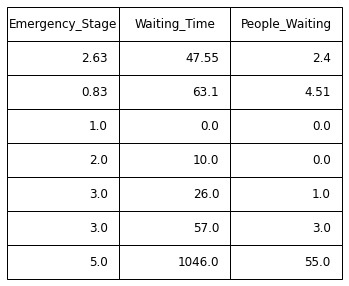

In [ ]:
def render_mpl_table(data, col_width=7.0, row_height=0.625, font_size=12,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)



render_mpl_table(df_numerical_ft, header_columns=0, col_width=2.0)

In [ ]:
#Ver de quando a quando os dados foram recolhidos
print(max(data["Acquisition_Time"]))
print(min(data["Acquisition_Time"]))

2019-04-29 23:59:41
2017-11-15 00:01:10


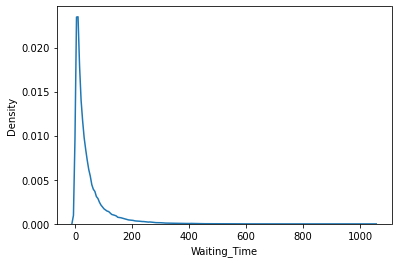

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.kdeplot(data["Waiting_Time"])
plt.show()
plt.savefig("kde_waiting_time.jpg")

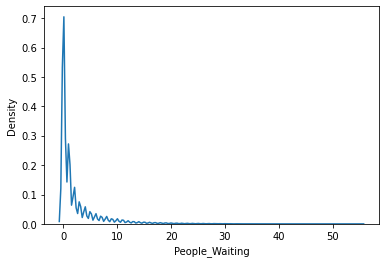

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.kdeplot(data["People_Waiting"])
plt.show()
plt.savefig("kde_people_waiting.jpg")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


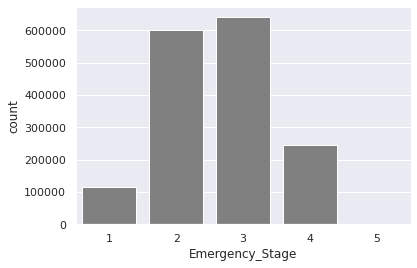

In [ ]:
sns.set()
sns.countplot(data["Emergency_Stage"], color = "grey")

         Emergency_Stage  Waiting_Time  People_Waiting
0                      4            17               0
1                      3            34               0
2                      3             6               0
3                      3             5               0
4                      2           309               8
...                  ...           ...             ...
1603379                4            13               0
1603380                3            10               0
1603381                3            53              13
1603382                2            52               1
1603383                2           137               9

[1603384 rows x 3 columns]


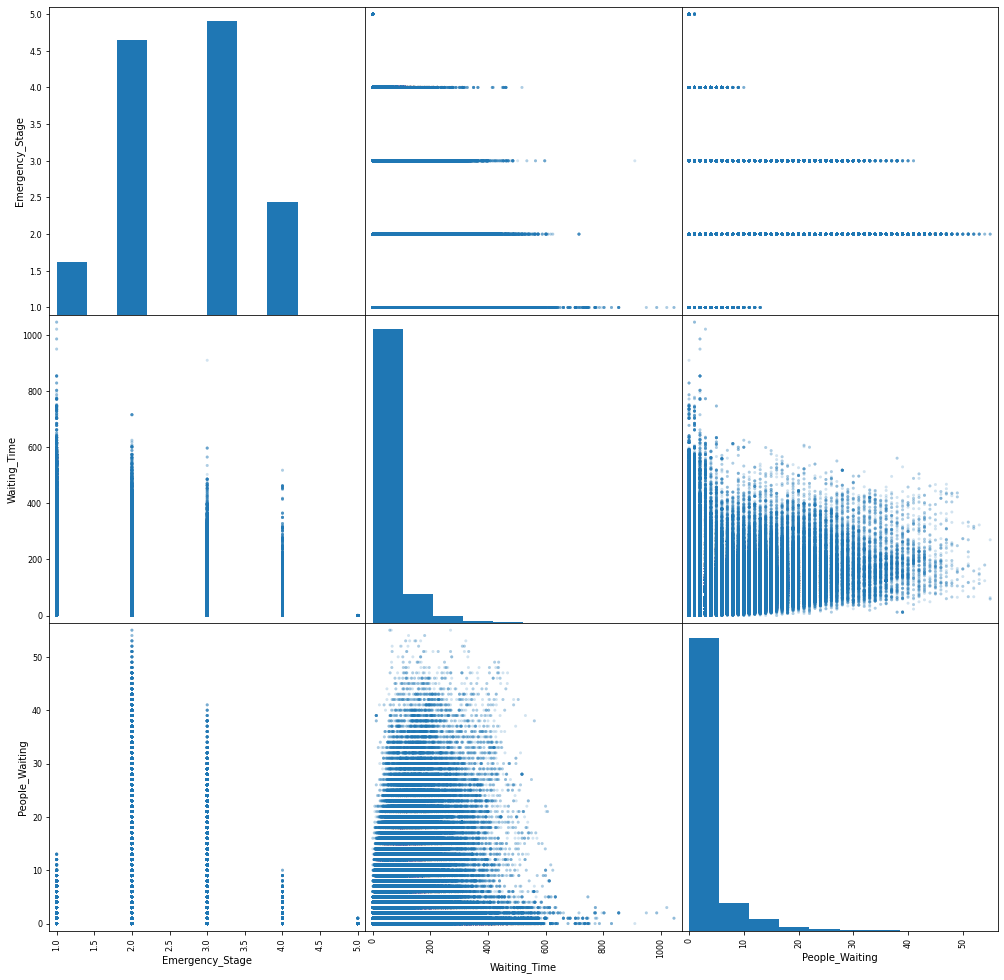

In [ ]:
data_num = data[["Emergency_Stage", "Waiting_Time", "People_Waiting"]]
print(data_num)

scatter_plot = scatter_matrix(data_num, alpha=0.2, figsize=(17,17), diagonal='hist') #na diagonal colocamos o Kernel Density Estimation para vermos o aspeto da distribuição de cada variável 
scatter_plot
plt.savefig("scatter_plot.jpg")

### Descriptive analysis - Group By Hospital 

In [ ]:
round(data.groupby("H_Name").mean()[["Waiting_Time", "People_Waiting"]], 1)

,Waiting_Time,People_Waiting
H_Name,,
Estefania,31.1,3.2
S Jose,42.3,1.8
SFX,42.4,1.3
Santa Maria,69.6,4.1


In [ ]:
data.groupby(["H_Name", "Service"]).mean()[["Waiting_Time", "People_Waiting"]].head(163)

Waiting_Time  People_Waiting
H_Name      Service                                                         
Estefania   Espera: Cirurgia                       23.454436        1.379060
            Espera: Ortopedia                      20.008143        1.570801
            Espera: Otorrino                       63.246753        1.010823
            Espera: Pediatria                      34.637584        3.857595
S Jose      Aguarda Atendimento Geral              87.000000        6.500000
            Aguarda Balcao (Cirurgia)              71.000000        0.000000
            Aguarda Balcao (Medico)                22.062500        0.781250
            Aguarda Balcao Trauma                  32.083333        0.250000
            Aguarda Cirurgia Plastica              51.000000        0.000000
            Aguarda Pequena Cirurgia Geral         17.714286        0.000000
            Aguarda Sector Ortopedico              38.000000        0.600000
            Aguarda Sector Psiquiatria             58.500000        0.000000
            Espera por 1 observacao medica         26.625000        3.625000
            Espera: Cirurgia Geral                 20.602739        0.218768
            Espera: Medicina Interna               75.624086        4.151381
            Espera: Oftalmologia                   18.596297        0.267062
            Espera: Ortopedia                      15.842994        0.231752
            Espera: Otorrinolaringologia           19.653315        0.157011
            Espera: Pequena Cirurgia               28.442544        0.339924
SFX         Aguarda Atendimento Geral             101.775545        4.969049
            Aguarda Balcao (Cirurgia)              28.303793        0.058099
            Aguarda Balcao (Medico)                45.361691        1.143286
            Aguarda Balcao Trauma                  26.880558        0.156202
            Aguarda Cirurgia Plastica              50.796783        0.050722
            Aguarda Pequena Cirurgia Geral         39.034882        0.273581
            Aguarda Sector Ortopedico              43.863641        0.573772
            Aguarda Sector Psiquiatria             36.510248        0.149502
            Aguardar Vaga/ECO/CTG/ Terapeutica     58.903709        0.252287
            Bloco de Partos                        38.114650        0.012739
            Espera por 1 observacao medica         11.300382        1.435538
            Espera: Cirurgia Geral                 15.250000        0.300000
            Espera: Medicina Interna               48.192308        2.365385
            Espera: Oftalmologia                   15.916667        0.333333
            Espera: Ortopedia                      13.294118        0.294118
            Espera: Otorrinolaringologia           34.600000        0.400000
            Espera: Pediatria                      17.333333        3.000000
            Espera: Pequena Cirurgia               50.200000        0.800000
            Sala de Espera Pos-Triagem             34.486700        0.242734
Santa Maria Aguarda Atendimento Geral              81.500000        5.166667
            Aguarda Balcao (Cirurgia)              57.500000        0.250000
            Aguarda Balcao (Medico)                25.346154        0.730769
            Aguarda Balcao Trauma                  39.818182        0.090909
            Aguarda Pequena Cirurgia Geral         36.500000        0.333333
            Aguarda Sector Ortopedico              38.888889        0.444444
            Cirurgia                               57.078286        2.396371
            Espera por 1 observacao medica          8.833333        1.000000
            Espera: Cirurgia                       78.333333        1.833333
            Espera: Otorrino                       16.000000        1.000000
            Espera: Pediatria                      15.925926        2.259259
            Medicina                               79.960598        5.595715

Group by Pulseira 

In [ ]:
a = round(data.groupby(["H_Name", "Emergency_Stage"]).mean()[["Waiting_Time"]], 1)
a

Waiting_Time
H_Name      Emergency_Stage              
Estefania   1                        52.7
            2                        37.2
            3                        30.2
            4                        14.1
            5                         0.0
S Jose      1                       135.5
            2                        49.7
            3                        31.8
            4                         9.7
            5                         0.0
SFX         1                       123.2
            2                        53.5
            3                        32.6
            4                        14.1
            5                         0.0
Santa Maria 1                       130.0
            2                        80.3
            3                        61.8
            4                        24.3
            5                         0.0


# Feature Engineer



In [ ]:
from river import stats

# Create new feature - Avg waiting time last 30 minute
df1=data[['H_Name','Service','Emergency_Stage','Acquisition_Time','People_Waiting','Waiting_Time']].copy()
df1 = data.loc[(df1['H_Name']=="Santa Maria")]

#Lag
Lag_value = 3 ## a data point every 10 mn -> we look at the value on the last 30 mn (3*10 mn)
#Lag_value_day =  6 * 24
#Lag_value_week =  6 * 24 * 7 ## a data point every 10 mn -> 6 per hour --> we look at the value on the last week
#Lag_value_day_hora = 6 #para a mesma hora do dia anterior

#Create new columns with hour and weekday of acquisition time
#df1["hour"] = df1["Acquisition_Time"].dt.hour
#df1["weekday"] = df1["Acquisition_Time"].dt.weekday

#Create new columns to get means of previous waiting times
df1["Waiting_Time_30_mn"] = 0
#df1["Waiting_Time_day"] = 0
#df1["lag_Waiting_Time_week"] = 0
#df1["same_hour_yesterday"] = 0
#df1["same_weekday_hour"] = 0

hospital_list = list(df1["H_Name"].unique())
service = df1.explode('Service').groupby('H_Name')['Service'].unique().reset_index()


for H in hospital_list:
  x=service.loc[service['H_Name']==H]['Service'].tolist()[0]
  for s in x: 
    for em in range(1, len(data["Emergency_Stage"].unique()) + 1): #For each Emergency_Stage degree (from 1 to 5)
      #df1.loc[(df1['H_Name']==H) & (df1['Service']==s) & (df1['Emergency_Stage']==em),'Waiting_Time_day'] = df1[(df1['H_Name']==H) & (df1['Service']==s) & (df1['Emergency_Stage']==em)].Waiting_Time.shift(Lag_value_day)
      #df1.loc[(df1['H_Name']==H) & (df1['Service']==s) & (df1['Emergency_Stage']==em),'Waiting_Time_week'] = df1[(df1['H_Name']==H) & (df1['Service']==s) & (df1['Emergency_Stage']==em)].Waiting_Time.shift(Lag_value_week)
      df1.loc[(df1['H_Name']==H) & (df1['Service']==s) & (df1['Emergency_Stage']==em),'Waiting_Time_30_mn'] = df1[(df1['H_Name']==H) & (df1['Service']==s) & (df1['Emergency_Stage']==em)].Waiting_Time.shift(Lag_value)

"""


for H in hospital_list:
  x=service.loc[service['H_Name']==H]['Service'].tolist()[0]
  for s in x: 
    for em in range(1, len(data["Emergency_Stage"].unique()) + 1): #For each Emergency_Stage degree (from 1 to 5)
      for hour in range(24):
        df1.loc[(df1['H_Name']==H) & (df1['Service']==s) & (df1['Emergency_Stage']==em) & (df1['hour']==hour),'same_hour_yesterday'] =\
        df1[(df1['H_Name']==H) & (df1['Service']==s) & (df1['Emergency_Stage']==em) & (df1['hour']==hour)].Waiting_Time.shift(Lag_value_day_hora)
        for weekday in range(7):
          df1.loc[(df1['H_Name']==H) & (df1['Service']==s) & (df1['Emergency_Stage']==em) & (df1['weekday']==weekday) & (df1['hour']==hour),'same_weekday_hour'] =\
           df1[(df1['H_Name']==H) & (df1['Service']==s) & (df1['Emergency_Stage']==em) & (df1['weekday']==weekday) & (df1['hour']==hour)].Waiting_Time.shift(Lag_value_day_hora)
"""

df2 = df1.dropna().copy() #drop values with NaN
df2.sample(25)
print(df2.head(25))

# define target
y = df2.pop('Waiting_Time')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


     Unnamed: 0    Acquisition_Time  Hospital     Urgency_Type   Service  \
78           78 2017-11-15 00:33:05       218  Urgncia Central  Cirurgia   
79           79 2017-11-15 00:33:05       218  Urgncia Central  Medicina   
80           80 2017-11-15 00:33:05       218  Urgncia Central  Cirurgia   
81           81 2017-11-15 00:33:05       218  Urgncia Central  Medicina   
82           82 2017-11-15 00:33:05       218  Urgncia Central  Cirurgia   
83           83 2017-11-15 00:33:05       218  Urgncia Central  Medicina   
84           84 2017-11-15 00:33:05       218  Urgncia Central  Medicina   
100         100 2017-11-15 00:50:38       218  Urgncia Central  Cirurgia   
101         101 2017-11-15 00:50:38       218  Urgncia Central  Medicina   
102         102 2017-11-15 00:50:38       218  Urgncia Central  Cirurgia   
103         103 2017-11-15 00:50:38       218  Urgncia Central  Medicina   
104         104 2017-11-15 00:50:38       218  Urgncia Central  Cirurgia   
105         

In [ ]:
print(len(df2))

395774


#### Definir Função para retirar Hora e Dia




In [ ]:
# Define function to get hour and day from timestamp
def get_hour_day(x):
    '''this function receives a dataframe with a timestamp column and return the day and hour'''
    x['weekday'] = float(x['Acquisition_Time'].weekday()) # Mon:0,Tue:1,...,Sat:6,Sun:7
    x['hour'] = x['Acquisition_Time'].hour
    return x

- Definir Modelo:
O modelo recebe 4 features primarias 
  - 1. Servico, 2. Hospital em formato one-hotencoding porque as variaveis sao categoricas e as suas distancias são iguais; o estado de emergencia do tipo int, pois apesar de categorica é uma varavel ordinária e a variável calculada previamente que representa a média do tempo de espera dos ultimos 30 minutos.

recebe ainda feature que calcula a mediia diaria por dia.

(emergente =  vermelho = 0 minutos; muito urgente =  laranja = 10 min; urgente =  amarelo = 60 min; menos urgente =  verde = 120 min; não urgente =  azul = 240 min)

# Implementar o Adwin para observarmos o drift

In [ ]:
from river import drift
delta = 10**(-140)

adwin = drift.ADWIN(delta = delta)
df_drift = data[['Acquisition_Time', 'Waiting_Time']].copy()

In [ ]:
from datetime import datetime
import time

# Update drift detector and verify if change is detected
drift_dates = []
input_values_drift = []

for row in range(len(df_drift)):
  in_drift, _ = adwin.update(int(df_drift[row:row+1]['Waiting_Time']))
  if in_drift:
    print(f"Change detected at index {row}, date {df_drift[row:row+1]['Acquisition_Time']}, input value: {int(df_drift[row:row+1]['Waiting_Time'])}")
    drift_dates += [df_drift[row:row+1]['Acquisition_Time']]
    input_values_drift += [int(df_drift[row:row+1]['Waiting_Time'])]
    adwin.reset()

Change detected at index 49195, date 49195   2017-11-30 14:47:35
Name: Acquisition_Time, dtype: datetime64[ns], input value: 8
Change detected at index 90699, date 90699   2017-12-13 01:34:52
Name: Acquisition_Time, dtype: datetime64[ns], input value: 4
Change detected at index 148043, date 148043   2018-01-02 16:24:59
Name: Acquisition_Time, dtype: datetime64[ns], input value: 19
Change detected at index 161611, date 161611   2018-01-06 14:32:57
Name: Acquisition_Time, dtype: datetime64[ns], input value: 46
Change detected at index 276299, date 276299   2018-02-14 20:53:28
Name: Acquisition_Time, dtype: datetime64[ns], input value: 128
Change detected at index 388267, date 388267   2018-03-21 14:23:12
Name: Acquisition_Time, dtype: datetime64[ns], input value: 8
Change detected at index 1043627, date 1043627   2018-11-01 10:59:59
Name: Acquisition_Time, dtype: datetime64[ns], input value: 14
Change detected at index 1554123, date 1554123   2019-04-14 00:36:42
Name: Acquisition_Time, d

In [ ]:
results_drift = {"Date of drift": ["2017-11-30", "2017-12-13", "2018-01-02",  "2018-01-06", "2018-02-14", "2018-03-21", "2018-11-01", "2019-04-14"]}
pd.DataFrame(results_drift)

,Date of drift
0,2017-11-30
1,2017-12-13
2,2018-01-02
3,2018-01-06
4,2018-02-14
5,2018-03-21
6,2018-11-01
7,2019-04-14


# Models

## **Rolling mean** 

#### Exemplo ao prever com 10 mintuos de antecdencia

In [ ]:
from river import stats

interval = 6 
data_m_a = data.loc[(data['H_Name']=="Santa Maria") & (data['Service']=="Cirurgia")  & (data['Emergency_Stage']==1)]
data_moving_average_10 = data_m_a[["Waiting_Time"]][0:50]
data_moving_average_10["Moving_Average"] = 0
data_moving_average_10["MAE"] = 0


for i in range(interval, len(data_moving_average_10)):
  for j in range(interval):
    data_moving_average_10["Moving_Average"][i:i+1] += int(data_moving_average_10["Waiting_Time"][i-j-1:i-j]) #(usar j-1 pq o primeiro j é 0)
  data_moving_average_10["Moving_Average"][i:i+1] = round(int(data_moving_average_10["Moving_Average"][i:i+1])/interval, 2)
  data_moving_average_10["MAE"][i:i+1] = abs(int(data_moving_average_10["Waiting_Time"][i:i+1]) - int(data_moving_average_10["Moving_Average"][i:i+1]))

print(data_moving_average_10)

      Waiting_Time  Moving_Average  MAE
715             18            0.00    0
727             18            0.00    0
741             18            0.00    0
756             18            0.00    0
771             18            0.00    0
790             18            0.00    0
812             35           18.00   17
835             35           20.83   15
859             35           23.67   12
886             35           26.50    9
914             35           29.33    6
944             35           32.17    3
976             35           35.00    0
1007            35           35.00    0
1039            35           35.00    0
1072            35           35.00    0
1107            35           35.00    0
1139            35           35.00    0
1173            51           35.00   16
1207            51           37.67   14
1243            51           40.33   11
1278            51           43.00    8
1312            49           45.67    4
1347            49           48.00    1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Prever com 1h de antecedencia, para todos os urgency stage

In [ ]:
interval = 6 #intervalo para realizar a media
step = 6 #step de antecedencia com que consigo dizer os resultados

data_m_a = data.loc[(data['H_Name']=="Santa Maria") & (data['Service']=="Cirurgia")  & (data['Emergency_Stage']==1)]
data_moving_average_1h = data_m_a[["Waiting_Time"]]
data_moving_average_1h["Moving_Average"] = 0
data_moving_average_1h["MAE"] = 0


for i in range(interval + step, len(data_moving_average_1h)):
  for j in range(interval):
    data_moving_average_1h["Moving_Average"][i:i+1] += int(data_moving_average_1h["Waiting_Time"][i-j-1-step:i-j-step]) #(usar j-1 pq o primeiro j é 0)
  data_moving_average_1h["Moving_Average"][i:i+1] = round(int(data_moving_average_1h["Moving_Average"][i:i+1])/interval, 2)
  data_moving_average_1h["MAE"][i:i+1] = abs(int(data_moving_average_1h["Waiting_Time"][i:i+1]) - int(data_moving_average_1h["Moving_Average"][i:i+1]))

#Remove 0s from calculations
data_moving_average_1h = data_moving_average_1h[interval+step:-1]

print(data_moving_average_1h)
print("For emergency stage = 1, the mean MAE was: ", data_moving_average_1h["MAE"].mean(axis = 0))
print("Lenght of this df: ", len(data_moving_average_1h))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

         Waiting_Time  Moving_Average  MAE
976                35           18.00   17
1007               35           20.83   15
1039               35           23.67   12
1072               35           26.50    9
1107               35           29.33    6
...               ...             ...  ...
1602510            55           28.50   27
1602544           106           18.17   88
1602580           113            7.83  106
1602616           113            7.00  106
1602652           113           15.00   98

[21302 rows x 3 columns]
70.16937376772134


In [ ]:
interval = 6 #intervalo para realizar a media
step = 6 #step de antecedencia com que consigo dizer os resultados

data_m_a = data.loc[(data['H_Name']=="Santa Maria") & (data['Service']=="Cirurgia")  & (data['Emergency_Stage']==2)]
data_moving_average_1h = data_m_a[["Waiting_Time"]]
data_moving_average_1h["Moving_Average"] = 0
data_moving_average_1h["MAE"] = 0


for i in range(interval + step, len(data_moving_average_1h)):
  for j in range(interval):
    data_moving_average_1h["Moving_Average"][i:i+1] += int(data_moving_average_1h["Waiting_Time"][i-j-1-step:i-j-step]) #(usar j-1 pq o primeiro j é 0)
  data_moving_average_1h["Moving_Average"][i:i+1] = round(int(data_moving_average_1h["Moving_Average"][i:i+1])/interval, 2)
  data_moving_average_1h["MAE"][i:i+1] = abs(int(data_moving_average_1h["Waiting_Time"][i:i+1]) - int(data_moving_average_1h["Moving_Average"][i:i+1]))

#Remove 0s from calculations
data_moving_average_1h = data_moving_average_1h[interval+step:-1]

print(data_moving_average_1h)
print("For emergency stage = 2, the mean MAE was: ", data_moving_average_1h["MAE"].mean(axis = 0))
print("Lenght of this df: ", len(data_moving_average_1h))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

         Waiting_Time  Moving_Average  MAE
258                37           32.00    5
276                42           32.17   10
295                42           33.00    9
314                50           33.17   17
333                50           34.00   16
...               ...             ...  ...
1603230            40           66.17   26
1603260            40           72.33   32
1603292            54           85.33   31
1603324            67           96.67   29
1603354            52          104.67   52

[62843 rows x 3 columns]
27.190029120188406


In [ ]:
interval = 6 #intervalo para realizar a media
step = 6 #step de antecedencia com que consigo dizer os resultados

data_m_a = data.loc[(data['H_Name']=="Santa Maria") & (data['Service']=="Cirurgia")  & (data['Emergency_Stage']==3)]
data_moving_average_1h = data_m_a[["Waiting_Time"]]
data_moving_average_1h["Moving_Average"] = 0
data_moving_average_1h["MAE"] = 0


for i in range(interval + step, len(data_moving_average_1h)):
  for j in range(interval):
    data_moving_average_1h["Moving_Average"][i:i+1] += int(data_moving_average_1h["Waiting_Time"][i-j-1-step:i-j-step]) #(usar j-1 pq o primeiro j é 0)
  data_moving_average_1h["Moving_Average"][i:i+1] = round(int(data_moving_average_1h["Moving_Average"][i:i+1])/interval, 2)
  data_moving_average_1h["MAE"][i:i+1] = abs(int(data_moving_average_1h["Waiting_Time"][i:i+1]) - int(data_moving_average_1h["Moving_Average"][i:i+1]))

#Remove 0s from calculations
data_moving_average_1h = data_moving_average_1h[interval+step:-1]

print(data_moving_average_1h)
print("For emergency stage = 3, the mean MAE was: ", data_moving_average_1h["MAE"].mean(axis = 0))
print("Lenght of this df: ", len(data_moving_average_1h))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

         Waiting_Time  Moving_Average  MAE
256                38           29.00    9
274                39           30.33    9
293                39           32.33    7
312                39           34.17    5
331                52           36.00   16
...               ...             ...  ...
1603228            71           29.67   42
1603258            71           30.83   41
1603290            83           31.67   52
1603322            17           35.83   18
1603352            10           43.67   33

[64681 rows x 3 columns]
For emergency stage = 3, the mean MAE was:  19.78162056863685
Lenght of this df:  64681


In [ ]:
interval = 6 #intervalo para realizar a media
step = 6 #step de antecedencia com que consigo dizer os resultados

data_m_a = data.loc[(data['H_Name']=="Santa Maria") & (data['Service']=="Cirurgia")  & (data['Emergency_Stage']==4)]
data_moving_average_1h = data_m_a[["Waiting_Time"]]
data_moving_average_1h["Moving_Average"] = 0
data_moving_average_1h["MAE"] = 0


for i in range(interval + step, len(data_moving_average_1h)):
  for j in range(interval):
    data_moving_average_1h["Moving_Average"][i:i+1] += int(data_moving_average_1h["Waiting_Time"][i-j-1-step:i-j-step]) #(usar j-1 pq o primeiro j é 0)
  data_moving_average_1h["Moving_Average"][i:i+1] = round(int(data_moving_average_1h["Moving_Average"][i:i+1])/interval, 2)
  data_moving_average_1h["MAE"][i:i+1] = abs(int(data_moving_average_1h["Waiting_Time"][i:i+1]) - int(data_moving_average_1h["Moving_Average"][i:i+1]))

#Remove 0s from calculations
data_moving_average_1h = data_moving_average_1h[interval+step:-1]

print(data_moving_average_1h)
print("For emergency stage = 4, the mean MAE was: ", data_moving_average_1h["MAE"].mean(axis = 0))
print("Lenght of this df: ", len(data_moving_average_1h))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

         Waiting_Time  Moving_Average  MAE
254                10           14.00    4
272                 4           13.00    9
291                 4           12.00    8
310                 4           11.00    7
329                 4           10.00    6
...               ...             ...  ...
1603166            16           12.67    4
1603196            16           11.50    5
1603226            16           10.33    6
1603256            16            7.67    9
1603350            53            5.00   48

[29898 rows x 3 columns]
For emergency stage = 4, the mean MAE was:  22.525386313465784
Lenght of this df:  29898


In [ ]:
interval = 6 #intervalo para realizar a media
step = 6 #step de antecedencia com que consigo dizer os resultados

data_m_a = data.loc[(data['H_Name']=="Santa Maria") & (data['Service']=="Cirurgia")  & (data['Emergency_Stage']==5)]
data_moving_average_1h = data_m_a[["Waiting_Time"]]
data_moving_average_1h["Moving_Average"] = 0
data_moving_average_1h["MAE"] = 0


for i in range(interval + step, len(data_moving_average_1h)):
  for j in range(interval):
    data_moving_average_1h["Moving_Average"][i:i+1] += int(data_moving_average_1h["Waiting_Time"][i-j-1-step:i-j-step]) #(usar j-1 pq o primeiro j é 0)
  data_moving_average_1h["Moving_Average"][i:i+1] = round(int(data_moving_average_1h["Moving_Average"][i:i+1])/interval, 2)
  data_moving_average_1h["MAE"][i:i+1] = abs(int(data_moving_average_1h["Waiting_Time"][i:i+1]) - int(data_moving_average_1h["Moving_Average"][i:i+1]))

#Remove 0s from calculations
data_moving_average_1h = data_moving_average_1h[interval+step:-1]

print(data_moving_average_1h)
print("For emergency stage = 5, the mean MAE was: ", data_moving_average_1h["MAE"].mean(axis = 0))
print("Lenght of this df: ", len(data_moving_average_1h))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

         Waiting_Time  Moving_Average  MAE
112749              0               0    0
112781              0               0    0
112812              0               0    0
112844              0               0    0
112878              0               0    0
...               ...             ...  ...
1487184             0               0    0
1487219             0               0    0
1487255             0               0    0
1487294             0               0    0
1487330             0               0    0

[94 rows x 3 columns]
For emergency stage = 5, the mean MAE was:  0.0
Lenght of this df:  94


In [ ]:
val_1 = 70.1693
len_1 = 21302
val_2 = 27.1900
len_2 = 62843
val_3 = 19.7816
len_3 = 64681
val_4 = 22.5253
len_4 = 29898
val_5 = 0.00
len_5 = 94
MAE_final = (val_1 * len_1 + val_2 * len_2 + val_3 * len_3 + val_4 * len_4 + val_5 * len_5 ) / (len_1 + len_2 + len_3 + len_4 + len_5 )
print(round(MAE_final, 2))

28.84


In [ ]:
len_1 + len_2 + len_3 + len_4 + len_5 

178818

In [ ]:
results_mov_avg = {"Emergency_Stage": [1,2,3,4,5, "Total"],
                   "Number of predictions": [21302, 62843, 64681, 29898, 94, 178818],
                   "Mean MAE": [70.17, 27.19, 19.78, 22.53, 0.00, 28.84]}

pd.DataFrame(results_mov_avg)

,Emergency_Stage,Number of predictions,Mean MAE
0,1,21302,70.17
1,2,62843,27.19
2,3,64681,19.78
3,4,29898,22.53
4,5,94,0.00
5,Total,178818,28.84


## **AdaptiveRandomForestRegressor**

In [ ]:
# Create model considering srvice,hospital,emergency_stage and AVG waiting time 
#inserir hospital depois
model1 = (compose.Select('Service', 'H_Name') | preprocessing.OneHotEncoder())
model1 += compose.Select('Emergency_Stage','Waiting_Time_30_mn', 'Waiting_Time_week')
model1 +=(get_hour_day | feature_extraction.TargetAgg(by='hour', how=stats.Mean()))

# Define model type
model1 |= preprocessing.StandardScaler()
model1 |= ensemble.AdaptiveRandomForestRegressor(seed=42, disable_weighted_vote = False, grace_period = 5, remove_poor_attrs = True) #max_depth
metric = metrics.MAE()

In [ ]:
model1

Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        H_Name
        Service
      ),
      OneHotEncoder (
        sparse=False
      )
    ),
    Select (
      Emergency_Stage
      lag_Waiting_Time_30_mn
      lag_Waiting_Time_week
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_day"
      ),
      TargetAgg (
        by=['hour']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  []
)

In [ ]:

# Avaliar modelos # fazer for para iterar sobre os modelos assemble random forest e HoeffdingTreeRegressor
# o streaming é criado aqui através da iter_pandas
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df2,y),
    model=model1,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000)

[20,000] MAE: 2,836,098,864.099391


KeyboardInterrupt: ignored

## **Regression**

In [ ]:
## Compose model
model2 = (compose.Select('Service', 'H_Name') | preprocessing.OneHotEncoder())
model2 += compose.Select('Emergency_Stage','Waiting_Time_30_mn')

model2 +=(get_hour_day | feature_extraction.TargetAgg(by='hour', how=stats.Mean()))

model2 |= fx.PolynomialExtender(degree=4, include_bias=False) #to test for different polynomials, select this row and change the degree number
model2 |= preprocessing.StandardScaler()
model2 |= linear_model.LinearRegression(l2=10,optimizer=optim.SGD(0.001))
metric = metrics.MAE()
metric2 = metrics.R2()

In [ ]:
model2

Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        H_Name
        Service
      ),
      OneHotEncoder (
        sparse=False
      )
    ),
    Select (
      Emergency_Stage
      Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_day"
      ),
      TargetAgg (
        by=['hour']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  PolynomialExtender (
    degree=4
    interaction_only=False
    include_bias=False
    bias_name="bias"
  ),
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.001
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

In [ ]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df2,y),
    model=model2,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000) 


[20,000] MAE: 2,407,577,769.752147
[40,000] MAE: 8,016,422,118.635548
[60,000] MAE: 9,197,120,734.777853
[80,000] MAE: 10,383,649,700.144703
[100,000] MAE: 11,041,963,582.813986
[120,000] MAE: 9,436,699,635.032703
[140,000] MAE: 8,582,421,251.320771
[160,000] MAE: 7,823,655,995.120235
[180,000] MAE: 6,980,736,875.329364
[200,000] MAE: 6,567,032,791.115376
[220,000] MAE: 6,401,333,299.878555
[240,000] MAE: 5,918,193,719.72718
[260,000] MAE: 6,466,169,132.439093
[280,000] MAE: 6,505,876,571.212776
[300,000] MAE: 7,084,596,064.69151
[320,000] MAE: 7,751,529,812.117869
[340,000] MAE: 7,818,224,674.436719
[360,000] MAE: 7,395,319,449.515661
[380,000] MAE: 7,081,416,339.166138


MAE: 6,799,442,805.488226

In [ ]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df2,y),
    model=model2,
    metric=metric2,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000)

[20,000] R2: 0.776761
[40,000] R2: 0.768097
[60,000] R2: 0.772292


KeyboardInterrupt: ignored

In [ ]:
results_regressions = {"Regression": ["Linear","Degree 2", "Degree 3","Degree 4"],
                       "Mean MAE": ["36.61", "26.27", "  7.54x10^6", "1"]}

pd.DataFrame(results_regressions)

,Regression,Mean MAE
0,Linear,36.61
1,Degree 2,26.27
2,Degree 3,7.54x10^6
3,Degree 4,1
4,Degree 5,1


## **KNN**

In [ ]:
## Compose model
model2 = (compose.Select('Service', 'H_Name') | preprocessing.OneHotEncoder())
model2 += compose.Select('Emergency_Stage','Waiting_Time_30_mn')

model2 +=(get_hour_day | feature_extraction.TargetAgg(by='hour', how=stats.Mean()))

model2 |= preprocessing.StandardScaler()
model2 |= neighbors.KNNRegressor(window_size=100, n_neighbors = 10)
metric = metrics.MAE()

In [ ]:
model2

Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        H_Name
        Service
      ),
      OneHotEncoder (
        sparse=False
      )
    ),
    Select (
      Emergency_Stage
      Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_day"
      ),
      TargetAgg (
        by=['hour']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  KNNRegressor (
    n_neighbors=10
    window_size=100
    leaf_size=30
    p=2
    aggregation_method="mean"
  )
)

In [ ]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df2,y),
    model=model2,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000)

[20,000] MAE: 16.154516
[40,000] MAE: 17.303393
[60,000] MAE: 17.937652
[80,000] MAE: 18.856392
[100,000] MAE: 18.891613
[120,000] MAE: 19.25219
[140,000] MAE: 19.724644


ValueError: ignored

## **Bagging Regressor**

In [ ]:
## Compose model
model3 = (compose.Select('Service', 'H_Name') | preprocessing.OneHotEncoder())
model3 += compose.Select('Emergency_Stage','Waiting_Time_30_mn')
model3 +=(get_hour_day | feature_extraction.TargetAgg(by='hour', how=stats.Mean()))

model3 |= fx.PolynomialExtender(degree=5, include_bias=False)
model3 |= preprocessing.StandardScaler()
model3 |= ensemble.BaggingRegressor(model=linear_model.LinearRegression(l2=10,intercept_lr=0.007), n_models=20) ##com diferentes poolinomiais 2 a 5

metric = metrics.MAE()

In [ ]:
model3

Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        H_Name
        Service
      ),
      OneHotEncoder (
        sparse=False
      )
    ),
    Select (
      Emergency_Stage
      Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_day"
      ),
      TargetAgg (
        by=['hour']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  PolynomialExtender (
    degree=5
    interaction_only=False
    include_bias=False
    bias_name="bias"
  ),
  StandardScaler (
    with_std=True
  ),
  [LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=10
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.007
    )
    clip_gradient=1e+12
    initial

In [ ]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df2,y),
    model=model3,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000)

## **Bagging KNN**

In [ ]:
## Compose model
model3 = (compose.Select('Service', 'H_Name') | preprocessing.OneHotEncoder())
model3 += compose.Select('Emergency_Stage','Waiting_Time_30_mn')
model3 +=(get_hour_day | feature_extraction.TargetAgg(by='hour', how=stats.Mean()))

model3 |= fx.PolynomialExtender(degree=5, include_bias=False)
model3 |= preprocessing.StandardScaler()
model3 |= ensemble.BaggingRegressor(model=neighbors.KNNRegressor(window_size=100, n_neighbors = 10)) ##com diferentes poolinomiais 2 a 5

metric = metrics.MAE()

In [ ]:
model3

In [ ]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df2,y),
    model=model3,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000)

[20,000] MAE: 16.33445
[40,000] MAE: 17.433139
[60,000] MAE: 18.067194
[80,000] MAE: 19.02777
[100,000] MAE: 19.091277
[120,000] MAE: 19.419671


## **SRPRegressor com Polinomial Regression**

In [ ]:
## Compose model
model_SRPR = (compose.Select('Service', 'H_Name') | preprocessing.OneHotEncoder())
model_SRPR += compose.Select('Emergency_Stage','Waiting_Time_30_mn')

model_SRPR +=(get_hour_day | feature_extraction.TargetAgg(by='hour', how=stats.Mean()))

model_SRPR |= fx.PolynomialExtender(degree=2, include_bias=False)
model_SRPR |= preprocessing.StandardScaler()
model_SRPR |= ensemble.SRPRegressor(model = linear_model.LinearRegression(optimizer=optim.SGD(0.0001)),
                                    training_method="patches",
                                    drift_detector= drift.ADWIN(),
                                    n_models=10,
                                    seed=42)
metric = metrics.MAE()

In [ ]:
model_SRPR

Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        H_Name
        Service
      ),
      OneHotEncoder (
        sparse=False
      )
    ),
    Select (
      Emergency_Stage
      Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_day"
      ),
      TargetAgg (
        by=['hour']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  PolynomialExtender (
    degree=2
    interaction_only=False
    include_bias=False
    bias_name="bias"
  ),
  StandardScaler (
    with_std=True
  ),
  SRPRegressor (
    model=LinearRegression (
      optimizer=SGD (
        lr=Constant (
          learning_rate=0.0001
        )
      )
      loss=Squared ()
      l2=0.
      intercept_init=0.
      intercept_lr=Constant (
        learning_rate=0.01
      )
      clip_gradient=1e+12
      initializer=Zeros ()
    )
    n_models=10
    subspace_size=0.6
    training_method="patches"
    lam=6.
    drift_detector=ADWIN (
      delta=0.002
    )
    warning_detector=ADWIN (
      delta=0.0001
    )
    disable_detector="off"
    disable_weighted_vote=True
    drift_detection_criteria="error"
    aggregation_method="mean"
    seed=42
    metric=MAE ()
  )
)

In [ ]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df2,y),
    model=model_SRPR,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000)

## **SRPR_Regressor com KNN**

In [ ]:
## Compose model
model_SRPR = (compose.Select('Service', 'H_Name') | preprocessing.OneHotEncoder())
model_SRPR += compose.Select('Emergency_Stage','Waiting_Time_30_mn')

model_SRPR +=(get_hour_day | feature_extraction.TargetAgg(by='hour', how=stats.Mean()))

model_SRPR |= preprocessing.StandardScaler()
model_SRPR |= ensemble.SRPRegressor(model = neighbors.KNNRegressor(window_size=100, n_neighbors = 10), # This works by storing a buffer with the window_size most recent observations
                                    training_method="patches",
                                    drift_detector= drift.ADWIN(),
                                    n_models=10,
                                    seed=42)
metric = metrics.MAE()

In [ ]:
model_SRPR

Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        H_Name
        Service
      ),
      OneHotEncoder (
        sparse=False
      )
    ),
    Select (
      Emergency_Stage
      Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_day"
      ),
      TargetAgg (
        by=['hour']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  SRPRegressor (
    model=KNNRegressor (
      n_neighbors=10
      window_size=100
      leaf_size=30
      p=2
      aggregation_method="mean"
    )
    n_models=2
    subspace_size=0.6
    training_method="patches"
    lam=6.
    drift_detector=ADWIN (
      delta=0.002
    )
    warning_detector=ADWIN (
      delta=0.0001
    )
    disable_detector="off"
    disable_weighted_vote=True
    drift_detection_criteria="error"
    aggregation_method="mean"
    seed=42
    metric=MAE ()
  )
)

In [ ]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df2,y),
    model=model_SRPR,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000)

[20,000] MAE: 14.803928
[40,000] MAE: 14.985511
[60,000] MAE: 14.883894
[80,000] MAE: 15.529316
[100,000] MAE: 15.442869
[120,000] MAE: 15.560149
[140,000] MAE: 15.895737
[160,000] MAE: 16.758739
[180,000] MAE: 17.484472
[200,000] MAE: 18.413136
[220,000] MAE: 19.376876
[240,000] MAE: 20.567552
[260,000] MAE: 21.470169
[280,000] MAE: 22.073242
[300,000] MAE: 22.98455
[320,000] MAE: 23.784098
[340,000] MAE: 24.759169
[360,000] MAE: 25.271524
[380,000] MAE: 25.613561


MAE: 26.076162

## **Comparing models' results**

In [ ]:
import pandas as pd
results_models = {"Model": ["Moving Averages", "Linear Regression","Polynomial Regression Degree 2", 
                            "Polynomial Regression Degree 3","Polynomial Regression Degree 4", "KNN",
                            "Bagging with PR Degree 2", "Bagging with KNN",
                            "SRPRegressor with PR Degree 2", "SRPRegressor with KNN"],
                  "Mean MAE": ["28.84", "36.61", "26.27", 
                               " 7.54x10^6", "6.8x10^9", "**",
                               "5.00x10^6", "**",
                               "36.52", "23.91",]}

pd.DataFrame(results_models)

,Model,Mean MAE
0,Moving Averages,28.84
1,Linear Regression,36.61
2,Polynomial Regression Degree 2,26.27
3,Polynomial Regression Degree 3,7.54x10^6
4,Polynomial Regression Degree 4,6.8x10^9
5,KNN,**
6,Bagging with PR Degree 2,5.00x10^6
7,Bagging with KNN,**
8,SRPRegressor with PR Degree 2,36.52
9,SRPRegressor with KNN,23.91


#BEST MODEL

##all features
## MAE e R2
##percentagem de erro para cada grau de urgencia!!! mais interessante que em minutos
##comparacao com 1 semana de avanco